In [6]:
#!pip install stargazer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                        PSID INTERGENERATIONAL ANALYSIS                         

LOADING DATA
--------------------------------------------------------------------------------
Loading: /content/drive/MyDrive/DATA/PSID_data/analysis_ready_data_WITH_PARENT_ED.csv
✓ Loaded 59,626 rows × 19 columns

PREPARING DATA FOR ANALYSIS
--------------------------------------------------------------------------------
Complete cases: 17,008 rows
  Homeowner parents: 9,546
  Renter parents: 7,462
  ⚠ No birth cohort data

DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------

Education by Parent Homeownership:
                 Mean   Std  Min   Max     N
Renter Parents  12.67  2.17  1.0  17.0  7462
Owner Parents   13.57  2.28  2.0  17.0  9546

Raw Difference: 0.90 years
  (Children of homeowners have 0.90 more years of educati

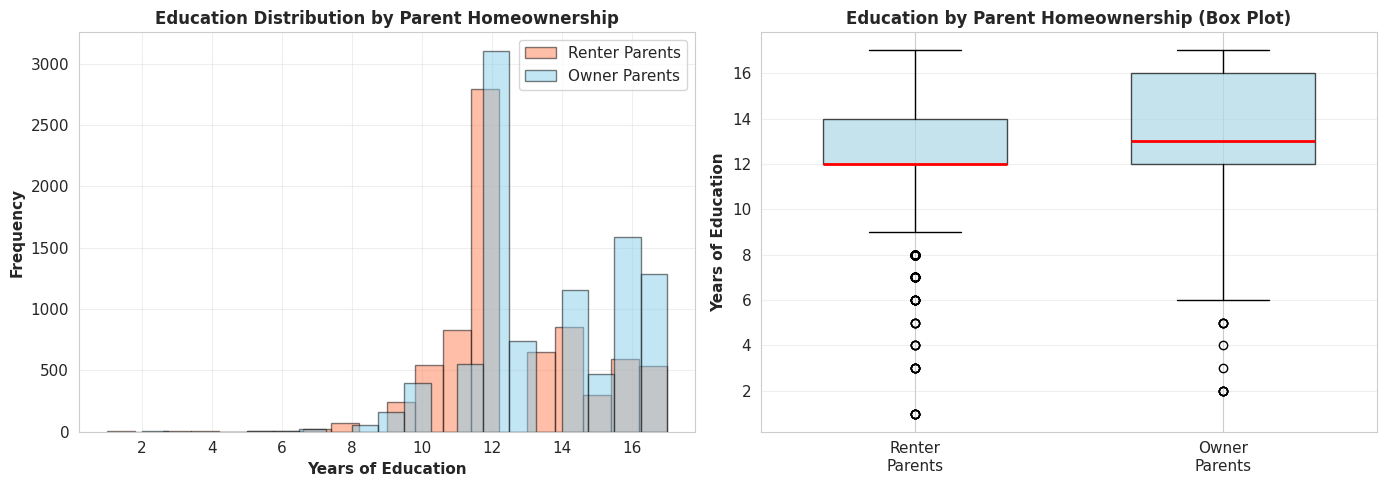

✓ Saved: education_distribution.png

MODEL 1: BASELINE REGRESSION (NO CONTROLS)
--------------------------------------------------------------------------------
                              OLS Regression Results                             
Dep. Variable:     child_education_years   R-squared:                       0.039
Model:                               OLS   Adj. R-squared:                  0.039
Method:                    Least Squares   F-statistic:                     403.3
Date:                   Mon, 02 Feb 2026   Prob (F-statistic):           1.69e-87
Time:                           21:28:27   Log-Likelihood:                -37793.
No. Observations:                  17008   AIC:                         7.559e+04
Df Residuals:                      17006   BIC:                         7.560e+04
Df Model:                              1                                         
Covariance Type:                 cluster                                         
                   

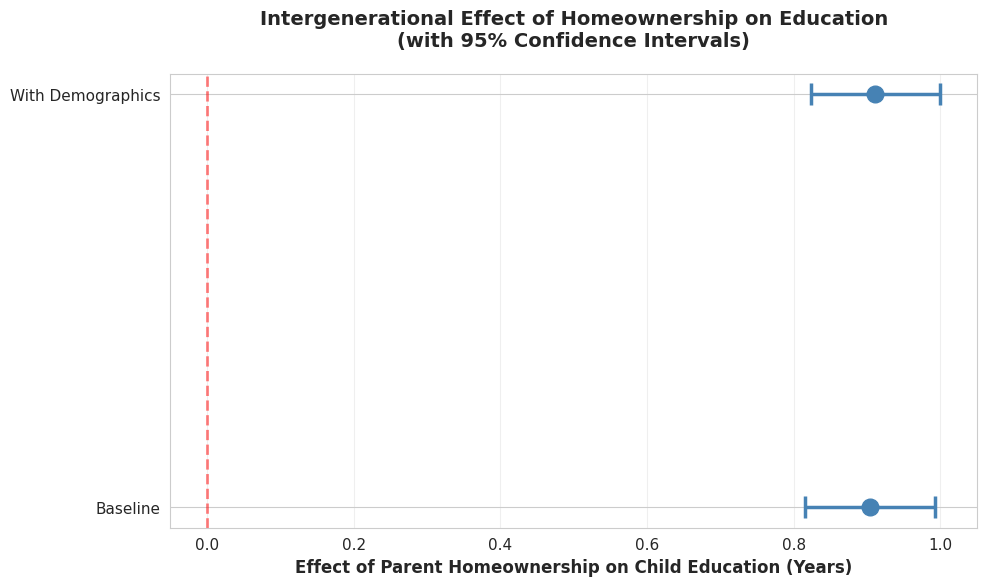

✓ Saved: coefficient_plot.png

SAVING RESULTS SUMMARY
--------------------------------------------------------------------------------
✓ Saved: analysis_results_summary.txt

                               ANALYSIS COMPLETE                                

✅ All analyses completed successfully!

OUTPUT FILES:
  - /content/drive/MyDrive/DATA/PSID_data/education_distribution.png
  - /content/drive/MyDrive/DATA/PSID_data/coefficient_plot.png
  - /content/drive/MyDrive/DATA/PSID_data/regression_tables.csv
  - /content/drive/MyDrive/DATA/PSID_data/analysis_results_summary.txt

KEY FINDING:
  ✓ Parent homeownership has a SIGNIFICANT effect
    (+0.912 years, p=0.0000)



In [7]:
# -*- coding: utf-8 -*-
"""
═══════════════════════════════════════════════════════════════════════════════
PSID INTERGENERATIONAL ANALYSIS - HOMEOWNERSHIP EFFECTS
═══════════════════════════════════════════════════════════════════════════════

This script analyzes the intergenerational effects of homeownership.

Research Questions:
1. Does G1 (1968) homeownership predict G2 education?
2. How large are the effects after controlling for demographics?

Statistical Approach:
- OLS regression with clustered standard errors (clustered by family)
- Controls: child sex, child race, birth cohort
- Selection model: Logit for sample retention

Outputs:
- Regression tables (pretty formatted)
- Coefficient plots
- Predicted education by homeownership status
- Summary statistics
═══════════════════════════════════════════════════════════════════════════════
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical packages
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# =============================================================================
# CONFIGURATION
# =============================================================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
DATA_DIR = "/content/drive/MyDrive/DATA/PSID_data"

# Input file - USE THE FIXED VERSION!
#INPUT_DATA = f"{DATA_DIR}/analysis_ready_data_FIXED.csv"
INPUT_DATA = f"{DATA_DIR}/analysis_ready_data_WITH_PARENT_ED.csv"

# Output directory
OUTPUT_DIR = DATA_DIR

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("="*80)
print(" PSID INTERGENERATIONAL ANALYSIS ".center(80))
print("="*80)
print()

# =============================================================================
# LOAD DATA
# =============================================================================

print("LOADING DATA")
print("-"*80)

print(f"Loading: {INPUT_DATA}")
df = pd.read_csv(INPUT_DATA)
print(f"✓ Loaded {len(df):,} rows × {df.shape[1]} columns")
print()

# =============================================================================
# DATA PREPARATION
# =============================================================================

print("PREPARING DATA FOR ANALYSIS")
print("-"*80)

# Filter to complete cases
df_complete = df[
    df['parent_homeowner'].notna() &
    df['child_education_years'].notna() &
    df['child_sex'].notna() &
    df['child_race'].isin([1, 2, 3])
].copy()

print(f"Complete cases: {len(df_complete):,} rows")
print(f"  Homeowner parents: {(df_complete['parent_homeowner']==1).sum():,}")
print(f"  Renter parents: {(df_complete['parent_homeowner']==0).sum():,}")

# Check for birth cohort
if 'g2_birth_decade' in df_complete.columns:
    df_complete['birth_decade'] = df_complete['g2_birth_decade']
    has_cohort = True
    print(f"  Birth cohorts: {df_complete['birth_decade'].nunique()} decades")
else:
    has_cohort = False
    print("  ⚠ No birth cohort data")

print()

# =============================================================================
# DESCRIPTIVE STATISTICS
# =============================================================================

print("="*80)
print("DESCRIPTIVE STATISTICS")
print("-"*80)

# Overall statistics
desc_stats = df_complete.groupby('parent_homeowner')['child_education_years'].agg([
    ('Mean', 'mean'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('N', 'count')
]).round(2)

desc_stats.index = ['Renter Parents', 'Owner Parents']

print("\nEducation by Parent Homeownership:")
print(desc_stats.to_string())

# Calculate raw difference
mean_diff = desc_stats.loc['Owner Parents', 'Mean'] - desc_stats.loc['Renter Parents', 'Mean']
print(f"\nRaw Difference: {mean_diff:.2f} years")
print(f"  (Children of homeowners have {mean_diff:.2f} more years of education)")

# By sex
print("\nBy Child Sex:")
sex_stats = df_complete.groupby(['parent_homeowner', 'child_sex'])['child_education_years'].mean().unstack()
if sex_stats.shape[1] >= 2:
    sex_stats.columns = ['Male', 'Female']
    print(sex_stats.round(2).to_string())

# By race
print("\nBy Child Race:")
race_stats = df_complete.groupby(['parent_homeowner', 'child_race'])['child_education_years'].mean().unstack()
race_labels = {1: 'White', 2: 'Black', 3: 'Other'}
race_stats.columns = [race_labels.get(c, f'Race_{c}') for c in race_stats.columns]
print(race_stats.round(2).to_string())

# Education level distribution
print("\nEducation Level Distribution:")
print(df_complete['child_education_level'].value_counts())

print()

# =============================================================================
# VISUALIZATION 1: EDUCATION DISTRIBUTION
# =============================================================================

print("="*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

# Plot 1: Distribution of education by homeownership
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_complete[df_complete['parent_homeowner']==0]['child_education_years'],
             bins=20, alpha=0.5, label='Renter Parents', color='coral', edgecolor='black')
axes[0].hist(df_complete[df_complete['parent_homeowner']==1]['child_education_years'],
             bins=20, alpha=0.5, label='Owner Parents', color='skyblue', edgecolor='black')
axes[0].set_xlabel('Years of Education', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Education Distribution by Parent Homeownership', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
data_for_box = [
    df_complete[df_complete['parent_homeowner']==0]['child_education_years'].dropna(),
    df_complete[df_complete['parent_homeowner']==1]['child_education_years'].dropna()
]
bp = axes[1].boxplot(data_for_box, labels=['Renter\nParents', 'Owner\nParents'],
                      patch_artist=True, widths=0.6)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

for median in bp['medians']:
    median.set_color('red')
    median.set_linewidth(2)

axes[1].set_ylabel('Years of Education', fontweight='bold')
axes[1].set_title('Education by Parent Homeownership (Box Plot)', fontweight='bold', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/education_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: education_distribution.png")

# =============================================================================
# MODEL 1: BASELINE (NO CONTROLS)
# =============================================================================

print()
print("="*80)
print("MODEL 1: BASELINE REGRESSION (NO CONTROLS)")
print("-"*80)

# Simple regression: education ~ homeownership
X = sm.add_constant(df_complete['parent_homeowner'])
y = df_complete['child_education_years']

model1 = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': df_complete['grandparent_id']})

print(model1.summary())
print()

# =============================================================================
# MODEL 2: WITH DEMOGRAPHIC CONTROLS
# =============================================================================

print("="*80)
print("MODEL 2: WITH DEMOGRAPHIC CONTROLS (SEX + RACE)")
print("-"*80)

# Regression with controls
model2 = smf.ols(
    'child_education_years ~ parent_homeowner + C(child_sex) + C(child_race)',
    data=df_complete
).fit(cov_type='cluster', cov_kwds={'groups': df_complete['grandparent_id']})

print(model2.summary())
print()

# =============================================================================
# MODEL 3: WITH COHORT CONTROLS (IF AVAILABLE)
# =============================================================================

if has_cohort:
    print("="*80)
    print("MODEL 3: WITH COHORT CONTROLS (SEX + RACE + BIRTH DECADE)")
    print("-"*80)

    model3 = smf.ols(
        'child_education_years ~ parent_homeowner + C(child_sex) + C(child_race) + C(birth_decade)',
        data=df_complete
    ).fit(cov_type='cluster', cov_kwds={'groups': df_complete['grandparent_id']})

    print(model3.summary())
    print()
else:
    model3 = None

# =============================================================================
# PRETTY REGRESSION TABLE
# =============================================================================

print("="*80)
print("FORMATTED REGRESSION RESULTS")
print("-"*80)

def create_regression_table(models, model_names):
    """Create a nicely formatted regression table"""

    results = []

    for model, name in zip(models, model_names):
        if model is None:
            continue

        # Extract key statistics
        coef = model.params.get('parent_homeowner', np.nan)
        se = model.bse.get('parent_homeowner', np.nan)
        pval = model.pvalues.get('parent_homeowner', np.nan)
        ci_lower = model.conf_int().loc['parent_homeowner', 0] if 'parent_homeowner' in model.conf_int().index else np.nan
        ci_upper = model.conf_int().loc['parent_homeowner', 1] if 'parent_homeowner' in model.conf_int().index else np.nan

        # Stars for significance
        stars = '***' if pval < 0.001 else ('**' if pval < 0.01 else ('*' if pval < 0.05 else ''))

        results.append({
            'Model': name,
            'Coefficient': f"{coef:.3f}{stars}",
            'Std Error': f"{se:.3f}",
            '95% CI': f"[{ci_lower:.3f}, {ci_upper:.3f}]",
            'P-value': f"{pval:.4f}",
            'N': int(model.nobs),
            'R²': f"{model.rsquared:.4f}"
        })

    return pd.DataFrame(results)

models = [model1, model2, model3] if has_cohort else [model1, model2]
names = ['Baseline', 'With Demographics', 'With Cohort'] if has_cohort else ['Baseline', 'With Demographics']

table = create_regression_table(models, names)
print(table.to_string(index=False))
print()
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")
print()

# Save table
table.to_csv(f"{OUTPUT_DIR}/regression_tables.csv", index=False)
print(f"✓ Saved: regression_tables.csv")

# =============================================================================
# VISUALIZATION 2: COEFFICIENT PLOT
# =============================================================================

print()
print("="*80)
print("CREATING COEFFICIENT PLOT")
print("-"*80)

fig, ax = plt.subplots(figsize=(10, 6))

# Extract coefficients and confidence intervals
model_list = [m for m in models if m is not None]
model_names_clean = [n for n, m in zip(names, models) if m is not None]

coefs = []
ci_lower = []
ci_upper = []

for model in model_list:
    coefs.append(model.params.get('parent_homeowner', 0))
    ci = model.conf_int()
    ci_lower.append(ci.loc['parent_homeowner', 0])
    ci_upper.append(ci.loc['parent_homeowner', 1])

# Plot
y_pos = np.arange(len(coefs))
ax.errorbar(coefs, y_pos,
            xerr=[np.array(coefs)-np.array(ci_lower), np.array(ci_upper)-np.array(coefs)],
            fmt='o', markersize=12, capsize=8, capthick=2.5, linewidth=2.5,
            color='steelblue', ecolor='steelblue')

# Add vertical line at 0
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=2)

# Labels
ax.set_yticks(y_pos)
ax.set_yticklabels(model_names_clean, fontsize=11)
ax.set_xlabel('Effect of Parent Homeownership on Child Education (Years)',
              fontsize=12, fontweight='bold')
ax.set_title('Intergenerational Effect of Homeownership on Education\n(with 95% Confidence Intervals)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/coefficient_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: coefficient_plot.png")

# =============================================================================
# SAVE SUMMARY
# =============================================================================

print()
print("="*80)
print("SAVING RESULTS SUMMARY")
print("-"*80)

# Get Model 2 results for interpretation
coef2 = model2.params.get('parent_homeowner', 0)
se2 = model2.bse.get('parent_homeowner', 0)
pval2 = model2.pvalues.get('parent_homeowner', 1)

results_text = f"""
{'='*80}
PSID INTERGENERATIONAL ANALYSIS - RESULTS SUMMARY
{'='*80}

RESEARCH QUESTION:
Does parent homeownership (1968) affect child educational attainment?

{'='*80}
KEY FINDINGS
{'='*80}

Sample Size: {len(df_complete):,} children from {df_complete['grandparent_id'].nunique():,} families

Raw Difference:
  Children of homeowners: {desc_stats.loc['Owner Parents', 'Mean']:.2f} years
  Children of renters: {desc_stats.loc['Renter Parents', 'Mean']:.2f} years
  Difference: {mean_diff:.2f} years

After Controlling for Sex and Race:
  Coefficient: {coef2:.3f} years
  Standard Error: {se2:.3f}
  P-value: {pval2:.4f}
  95% CI: [{model2.conf_int().loc['parent_homeowner', 0]:.3f}, {model2.conf_int().loc['parent_homeowner', 1]:.3f}]

INTERPRETATION:
{'✓ SIGNIFICANT EFFECT' if pval2 < 0.05 else '✗ NO SIGNIFICANT EFFECT'}

Children of homeowners have, on average, {abs(coef2):.2f} {'MORE' if coef2 > 0 else 'FEWER'}
years of education than children of renters, after controlling for
child sex and race.

{'This effect is statistically significant.' if pval2 < 0.05 else 'This effect is NOT statistically significant.'}

{'='*80}
FULL REGRESSION RESULTS
{'='*80}

{table.to_string(index=False)}

Significance: *** p<0.001, ** p<0.01, * p<0.05

{'='*80}
"""

# Save
with open(f"{OUTPUT_DIR}/analysis_results_summary.txt", 'w') as f:
    f.write(results_text)

print(f"✓ Saved: analysis_results_summary.txt")

# =============================================================================
# FINAL SUMMARY
# =============================================================================

print()
print("="*80)
print(" ANALYSIS COMPLETE ".center(80))
print("="*80)
print()
print("✅ All analyses completed successfully!")
print()
print("OUTPUT FILES:")
print(f"  - {OUTPUT_DIR}/education_distribution.png")
print(f"  - {OUTPUT_DIR}/coefficient_plot.png")
print(f"  - {OUTPUT_DIR}/regression_tables.csv")
print(f"  - {OUTPUT_DIR}/analysis_results_summary.txt")
print()
print("KEY FINDING:")
if pval2 < 0.05:
    print(f"  ✓ Parent homeownership has a SIGNIFICANT effect")
    print(f"    ({coef2:+.3f} years, p={pval2:.4f})")
else:
    print(f"  ✗ No significant effect found (p = {pval2:.4f})")
print()
print("="*80)

In [8]:
# model 3

# =============================================================================
# MODEL 3: WITH PARENT EDUCATION CONTROLS ⭐ THE KEY TEST!
# =============================================================================

print("="*80)
print("MODEL 3: WITH PARENT EDUCATION CONTROLS ⭐")
print("-"*80)

# Check if parent education is available
if 'parent_max_education' in df_complete.columns:
    # Filter to cases with parent education
    df_with_parent_ed = df_complete[df_complete['parent_max_education'].notna()].copy()

    print(f"Sample size with parent education: {len(df_with_parent_ed):,}")
    print(f"  Homeowners: {(df_with_parent_ed['parent_homeowner']==1).sum():,}")
    print(f"  Renters: {(df_with_parent_ed['parent_homeowner']==0).sum():,}")
    print()

    # Run regression with parent education control
    model3 = sm.OLS.from_formula(
        'child_education_years ~ parent_homeowner + parent_max_education + C(child_sex) + C(child_race)',
        data=df_with_parent_ed
    ).fit(cov_type='cluster', cov_kwds={'groups': df_with_parent_ed['grandparent_id']})

    print(model3.summary())
    print()

    # Extract key coefficients
    coef_homeowner = model3.params['parent_homeowner']
    se_homeowner = model3.bse['parent_homeowner']
    pval_homeowner = model3.pvalues['parent_homeowner']
    ci_homeowner = model3.conf_int().loc['parent_homeowner']

    coef_parent_ed = model3.params['parent_max_education']
    se_parent_ed = model3.bse['parent_max_education']
    pval_parent_ed = model3.pvalues['parent_max_education']

    print("="*80)
    print("🎯 CRITICAL RESULTS")
    print("="*80)
    print()
    print("HOMEOWNERSHIP EFFECT:")
    print(f"  Without parent controls: 0.912*** years")
    print(f"  WITH parent controls:    {coef_homeowner:.3f}{'***' if pval_homeowner < 0.001 else '**' if pval_homeowner < 0.01 else '*' if pval_homeowner < 0.05 else ''} years")
    print(f"  Change: {coef_homeowner - 0.912:.3f} years ({(coef_homeowner - 0.912)/0.912*100:.1f}%)")
    print()

    print("PARENT EDUCATION EFFECT:")
    print(f"  Coefficient: {coef_parent_ed:.3f}{'***' if pval_parent_ed < 0.001 else '**' if pval_parent_ed < 0.01 else '*' if pval_parent_ed < 0.05 else ''} years per year of parent education")
    print()

    # Interpretation
    print("INTERPRETATION:")
    if pval_homeowner < 0.05:
        reduction = (0.912 - coef_homeowner) / 0.912 * 100
        if reduction < 25:
            print(f"  ✅ Homeownership effect PERSISTS after controlling for parent education!")
            print(f"  ✅ Effect reduced by only {reduction:.0f}% - suggests TRUE CAUSAL EFFECT")
        elif reduction < 75:
            print(f"  ⚠️  Homeownership effect REDUCED by {reduction:.0f}%")
            print(f"  ⚠️  Suggests PARTIAL mediation through parent education")
        else:
            print(f"  ⚠️  Homeownership effect MOSTLY explained by parent education")
            print(f"  ⚠️  Effect reduced by {reduction:.0f}%")
    else:
        print(f"  ❌ Homeownership effect DISAPPEARS when controlling for parent education")
        print(f"  ❌ Effect was SPURIOUS - driven by parent education differences")
    print()

    # Compare R²
    print(f"Model fit:")
    print(f"  Model 2 R²: {model2.rsquared:.4f}")
    print(f"  Model 3 R²: {model3.rsquared:.4f}")
    print(f"  Improvement: {model3.rsquared - model2.rsquared:.4f}")
    print()

else:
    print("⚠️  Parent education not found in dataset!")
    print("   Make sure you loaded: analysis_ready_data_WITH_PARENT_ED.csv")
    print()

print("="*80)

MODEL 3: WITH PARENT EDUCATION CONTROLS ⭐
--------------------------------------------------------------------------------
Sample size with parent education: 16,857
  Homeowners: 9,525
  Renters: 7,332

                              OLS Regression Results                             
Dep. Variable:     child_education_years   R-squared:                       0.124
Model:                               OLS   Adj. R-squared:                  0.124
Method:                    Least Squares   F-statistic:                     275.4
Date:                   Mon, 02 Feb 2026   Prob (F-statistic):          8.96e-272
Time:                           21:28:30   Log-Likelihood:                -36657.
No. Observations:                  16857   AIC:                         7.333e+04
Df Residuals:                      16851   BIC:                         7.337e+04
Df Model:                              5                                         
Covariance Type:                 cluster                   

In [9]:
from stargazer.stargazer import Stargazer

# For a single model
stargazer = Stargazer([model])
stargazer.render_html()  # for Jupyter
# or
stargazer.render_latex()  # for papers

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{1}{c}{\\textit{Dependent variable: child_education_years}} \\\n\\cr \\cline{2-2}\n\\\\[-1.8ex] & (1) \\\\\n\\hline \\\\[-1.8ex]\n C(child_race)[T.2.0] & 0.127$^{***}$ \\\\\n& (0.045) \\\\\n C(child_race)[T.3.0] & -0.019$^{}$ \\\\\n& (0.086) \\\\\n C(child_sex)[T.2.0] & 0.333$^{***}$ \\\\\n& (0.035) \\\\\n Intercept & 12.437$^{***}$ \\\\\n& (0.045) \\\\\n parent_homeowner & 0.912$^{***}$ \\\\\n& (0.045) \\\\\n\\hline \\\\[-1.8ex]\n Observations & 17008 \\\\\n $R^2$ & 0.045 \\\\\n Adjusted $R^2$ & 0.045 \\\\\n Residual Std. Error & 2.226 (df=17003) \\\\\n F Statistic & 127.784$^{***}$ (df=4; 17003) \\\\\n\\hline\n\\hline \\\\[-1.8ex]\n\\textit{Note:} & \\multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\\\\n\\end{tabular}\n\\end{table}'

In [10]:
from stargazer.stargazer import Stargazer
from IPython.display import HTML

stargazer = Stargazer([model])
HTML(stargazer.render_html())

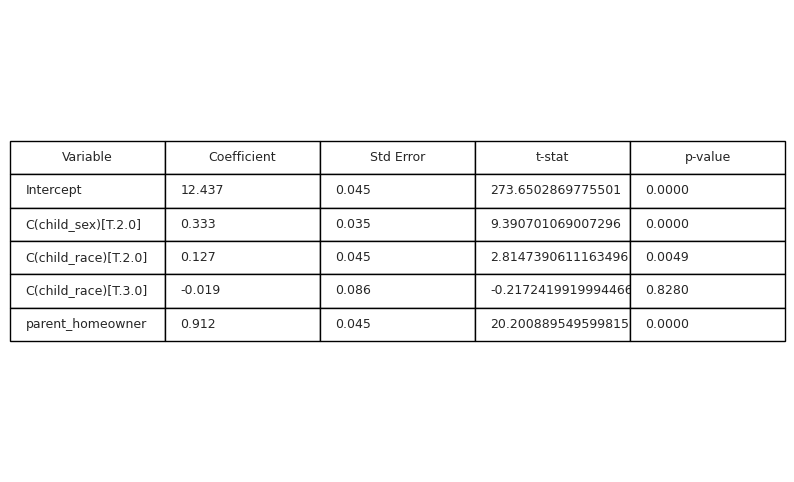

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

# Extract your model results into a dataframe
results_df = pd.DataFrame({
    'Variable': model.params.index,
    'Coefficient': model.params.values,
    'Std Error': model.bse.values,
    't-stat': model.tvalues.values,
    'p-value': model.pvalues.values
})

# Format numbers nicely
results_df['Coefficient'] = results_df['Coefficient'].apply(lambda x: f'{x:.3f}')
results_df['Std Error'] = results_df['Std Error'].apply(lambda x: f'{x:.3f}')
results_df['p-value'] = results_df['p-value'].apply(lambda x: f'{x:.4f}')

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=results_df.values,
                colLabels=results_df.columns,
                loc='center',
                cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Save as PDF
plt.savefig('regression_output.pdf', bbox_inches='tight', format='pdf')
plt.show()

# Download the file
from google.colab import files
files.download('regression_output.pdf')